# Unconditioned, continous generation

## Install dependencies

In [96]:
import os
import numpy as np
import pretty_midi
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import IPython.display as ipd
from pypianoroll import Track, Multitrack
import subprocess

Install dependency for YouTube package for additional dataset

In [ ]:
# Add another dataset
!pip install yt-dlp

Grab the videos and create midi files from them

In [100]:
# YouTube playlist URL
playlist_url = 'https://youtube.com/playlist?list=PLrXCURCvaqrw0SSmUSkXAwK5Ywsc857t9&si=t2u7k51YpxxToVEV'

# Create output folder
os.makedirs('./Temp', exist_ok=True)

# Step 1: Download up to 100 audio files with their titles in the filename
download_command = [
    'yt-dlp',
    '--playlist-end', '100',  # Stop after 100 items
    '-x', '--audio-format', 'wav',
    '-o', './Temp/%(title)s.%(ext)s',  # Save as {title}.wav
    playlist_url
]

print('Downloading up to 100 WAV files...')
subprocess.run(download_command, check=True)

# Step 2: Process each downloaded WAV file to MIDI
wav_files = sorted([f for f in os.listdir('./Temp') if f.endswith('.wav')])

for wav_file in wav_files:
    wav_path = os.path.join('./Temp', wav_file)
    print(f'Processing {wav_path}...')

    try:
        # Load audio
        y, sr = librosa.load(wav_path, sr=44100)

        # Extract pitches (monophonic)
        pitches, magnitudes = librosa.piptrack(y=y, sr=sr)

        # Convert to MIDI
        midi_data = pretty_midi.PrettyMIDI()
        track = pretty_midi.Instrument(program=0)  # Piano

        for t in range(pitches.shape[1]):
            freq = pitches[:, t][magnitudes[:, t].argmax()]
            if freq > 0:
                note_num = librosa.hz_to_midi(freq)
                note = pretty_midi.Note(
                    velocity=100,
                    pitch=int(note_num),
                    start=t * 0.1,
                    end=(t + 1) * 0.1
                )
                track.notes.append(note)

        midi_data.instruments.append(track)

        # Save as {title}.mid (same base name as wav)
        midi_filename = wav_file.replace('.wav', '.mid')
        midi_path = os.path.join('./Temp', midi_filename)
        midi_data.write(midi_path)
        print(f'Saved MIDI to {midi_path}')

    except Exception as e:
        print(f'Error processing {wav_file}: {e}')


[youtube:tab] Extracting URL: https://youtube.com/playlist?list=PLrXCURCvaqrw0SSmUSkXAwK5Ywsc857t9&si=t2u7k51YpxxToVEV
[youtube:tab] PLrXCURCvaqrw0SSmUSkXAwK5Ywsc857t9: Downloading webpage
[youtube:tab] PLrXCURCvaqrw0SSmUSkXAwK5Ywsc857t9: Redownloading playlist API JSON with unavailable videos
[download] Downloading playlist: KPOP Piano Covers (Kpop Piano Collections, Korean Pop Songs Piano Covers) by Pianella Piano
[youtube:tab] Playlist KPOP Piano Covers (Kpop Piano Collections, Korean Pop Songs Piano Covers) by Pianella Piano: Downloading 100 items of 644
[download] Downloading item 1 of 100
[youtube] Extracting URL: https://www.youtube.com/watch?v=xtqKprXY0xg
[youtube] xtqKprXY0xg: Downloading webpage
[youtube] xtqKprXY0xg: Downloading tv client config
[youtube] xtqKprXY0xg: Downloading tv player API JSON
[youtube] xtqKprXY0xg: Downloading ios player API JSON
[youtube] xtqKprXY0xg: Downloading m3u8 information
[info] xtqKprXY0xg: Downloading 1 format(s): 251
[download] Destination:

> Moved mid files to the Data folder for analysis

## Prepare the Data

In [ ]:
def load_midi_files(directory='./Data/', max_files=150, fs=25, min_length=50):
    """Load MIDI files with better error handling and consistent lengths"""
    if not os.path.exists(directory):
        print(f"Directory {directory} not found. Creating sample data...")
        return create_sample_data(max_files, fs, min_length)
    
    midi_files = [f for f in os.listdir(directory) if f.endswith('.mid')][:max_files]
    
    if not midi_files:
        print("No MIDI files found. Creating sample data...")
        return create_sample_data(max_files, fs, min_length)
    
    piano_rolls = []
    midi_data = []
    failed_files = []
    
    for midi_file in midi_files:
        try:
            file_path = os.path.join(directory, midi_file)
            pm = pretty_midi.PrettyMIDI(file_path)
            piano_roll = pm.get_piano_roll(fs=fs)
            
            # Verify piano roll shape and minimum length
            if piano_roll.shape[0] != 128:
                print(f"Unexpected shape {piano_roll.shape} for {midi_file}")
                continue
            
            if piano_roll.shape[1] < min_length:
                print(f"Too short ({piano_roll.shape[1]} steps) for {midi_file}")
                continue
                
            piano_roll = (piano_roll > 0).astype(float).T  # Transpose to (time, 128)
            piano_rolls.append(piano_roll)
            midi_data.append(pm)
            
        except Exception as e:
            failed_files.append((midi_file, str(e)))
            continue
    
    if failed_files:
        print(f"Failed to load {len(failed_files)} files:")
        for f, err in failed_files[:5]:
            print(f"- {f}: {err}")
    
    if not piano_rolls:
        print("No valid MIDI files loaded. Creating sample data...")
        return create_sample_data(max_files, fs, min_length)
    
    return piano_rolls, midi_data

def create_sample_data(num_samples=50, fs=25, min_length=200):
    """Create sample piano roll data for testing"""
    print("Creating synthetic piano roll data for testing...")
    piano_rolls = []
    midi_data = []
    
    for i in range(num_samples):
        # Create random piano roll with some structure
        length = np.random.randint(min_length, min_length * 3)
        piano_roll = np.zeros((length, 128))
        
        # Add some random notes with temporal structure
        for _ in range(np.random.randint(5, 20)):
            note = np.random.randint(21, 108)  # Piano range
            start = np.random.randint(0, length - 10)
            duration = np.random.randint(2, 15)
            end = min(start + duration, length)
            piano_roll[start:end, note] = 1.0
        
        piano_rolls.append(piano_roll)
        
        # Create corresponding MIDI object
        pm = pretty_midi.PrettyMIDI()
        instrument = pretty_midi.Instrument(program=0)
        
        for t in range(length):
            for note in range(128):
                if piano_roll[t, note] > 0:
                    # Check if this is the start of a note
                    if t == 0 or piano_roll[t-1, note] == 0:
                        # Find the end of this note
                        end_t = t
                        while end_t < length and piano_roll[end_t, note] > 0:
                            end_t += 1
                        
                        pm_note = pretty_midi.Note(
                            velocity=80,
                            pitch=note,
                            start=t / fs,
                            end=end_t / fs
                        )
                        instrument.notes.append(pm_note)
        
        pm.instruments.append(instrument)
        midi_data.append(pm)
    
    return piano_rolls, midi_data

# Load the data
piano_rolls, midi_objects = load_midi_files()
print(f"Loaded {len(piano_rolls)} piano rolls")

if not piano_rolls:
    raise ValueError("No data loaded. Please check your data directory or file paths.")

# Create sequences of consistent length for training
sequence_length = 128  # Use shorter sequences for memory efficiency
def create_sequences(piano_rolls, seq_length):
    """Create training sequences from piano rolls"""
    sequences = []
    targets = []
    
    for piano_roll in piano_rolls:
        if piano_roll.shape[0] < seq_length + 1:
            continue
            
        for i in range(0, piano_roll.shape[0] - seq_length, seq_length // 2):  # Overlapping sequences
            if i + seq_length + 1 >= piano_roll.shape[0]:
                break
            sequence = piano_roll[i:i + seq_length]
            target = piano_roll[i + 1:i + seq_length + 1]  # Next step prediction
            sequences.append(sequence)
            targets.append(target)
    
    return np.array(sequences), np.array(targets)

X, y = create_sequences(piano_rolls, sequence_length)
print(f"Created {X.shape[0]} sequences of shape {X.shape[1:]}")

# Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Failed to load 2 files:
- [Full Album] JISOO - AMORTAGE (1 Hour Playlist) ｜ earthquake, Your Love, TEARS, Hugs & Kisses.mid: MIDI file has a largest tick of 14017302, it is likely corrupt
- [Full Album] Jung Kook - GOLDEN ｜ Piano Cover by Pianella Piano.mid: MIDI file has a largest tick of 12915322, it is likely corrupt
Loaded 148 piano rolls
Created 59387 sequences of shape (128, 128)


## Utilize a LSTM model

In [ ]:
def build_lstm_model(input_shape, units=256, dropout=0.3):
    """Build an LSTM model for MIDI generation"""
    model = tf.keras.Sequential([
        layers.LSTM(units, return_sequences=True, input_shape=input_shape),
        layers.Dropout(dropout),
        layers.LSTM(units, return_sequences=True),
        layers.Dropout(dropout),
        layers.LSTM(units, return_sequences=True),
        layers.Dropout(dropout),
        layers.Dense(128, activation='sigmoid')  # 128 notes
    ])
    return model

model = build_lstm_model(input_shape=(sequence_length, 128))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/opt/anaconda3/envs/musicgen/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 128, 256)       │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 128, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 128, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128, 128)       │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,477,760 (5.64 MB)

 Trainable params: 1,477,760 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [ ]:
print("Starting training...")
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-4)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Starting training...
Epoch 1/50
 355/1485 ━━━━━━━━━━━━━━━━━━━━ 6:56 368ms/step - accuracy: 0.0684 - loss: 0.0359

## Generate the music

In [ ]:
def generate_music(model, seed_sequence=None, length=200, temperature=0.8):
    """Generate music using the trained model"""
    if seed_sequence is None:
        # Use a random sequence from training data as seed
        seed_idx = np.random.randint(0, X_train.shape[0])
        seed_sequence = X_train[seed_idx:seed_idx+1]  # Shape: (1, seq_len, 128)
    else:
        seed_sequence = seed_sequence.reshape(1, -1, 128)
    
    generated = []
    current_sequence = seed_sequence.copy()
    
    print(f"Generating {length} time steps...")
    for i in tqdm(range(length)):
        # Predict next step
        prediction = model.predict(current_sequence, verbose=0)[0, -1, :]  # Last time step
        
        # Apply temperature to control randomness
        if temperature > 0:
            prediction = np.log(np.maximum(prediction, 1e-8)) / temperature
            prediction = np.exp(prediction) / np.sum(np.exp(prediction))
        
        # Sample from the prediction
        next_notes = np.random.binomial(1, prediction).astype(float)
        generated.append(next_notes)
        
        # Update sequence for next prediction
        next_step = next_notes.reshape(1, 1, 128)
        current_sequence = np.concatenate([current_sequence[:, 1:, :], next_step], axis=1)
    
    return np.array(generated)

## Save the Generated Music as .mid

In [ ]:
print("Generating new music...")
generated_sequence = generate_music(model, length=300, temperature=0.7)

def piano_roll_to_midi(piano_roll, fs=25, program=0):
    """Convert piano roll to PrettyMIDI object"""
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)
    
    # Track active notes
    active_notes = {}
    
    for t, frame in enumerate(piano_roll):
        current_time = t / fs
        
        # Check each note
        for note_num in range(128):
            is_active = frame[note_num] > 0.5
            
            if is_active and note_num not in active_notes:
                # Note on
                active_notes[note_num] = current_time
            elif not is_active and note_num in active_notes:
                # Note off
                start_time = active_notes[note_num]
                note = pretty_midi.Note(
                    velocity=80,
                    pitch=note_num,
                    start=start_time,
                    end=current_time
                )
                instrument.notes.append(note)
                del active_notes[note_num]
    
    # Close any remaining active notes
    final_time = len(piano_roll) / fs
    for note_num, start_time in active_notes.items():
        note = pretty_midi.Note(
            velocity=80,
            pitch=note_num,
            start=start_time,
            end=final_time
        )
        instrument.notes.append(note)
    
    pm.instruments.append(instrument)
    return pm

# Create MIDI file
generated_midi = piano_roll_to_midi(generated_sequence, fs=25)
generated_midi.write('./Generated/generated_music.mid')
print("Generated music saved as 'generated_music.mid'")

Generating new music...
Generating 300 time steps...


100%|██████████| 300/300 [00:20<00:00, 14.92it/s]


Generated music saved as 'generated_music.mid'


> Renamed generated midis so there are different samples

## Listen to Greatness

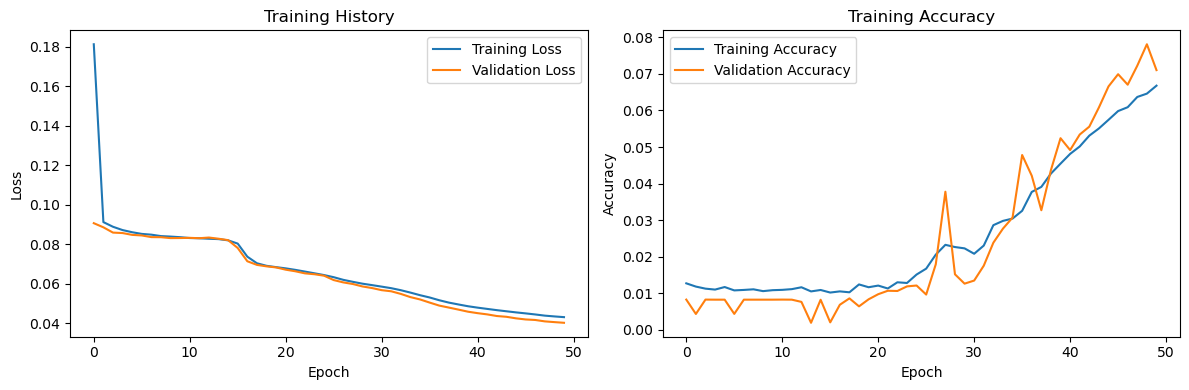

Sample from training data:


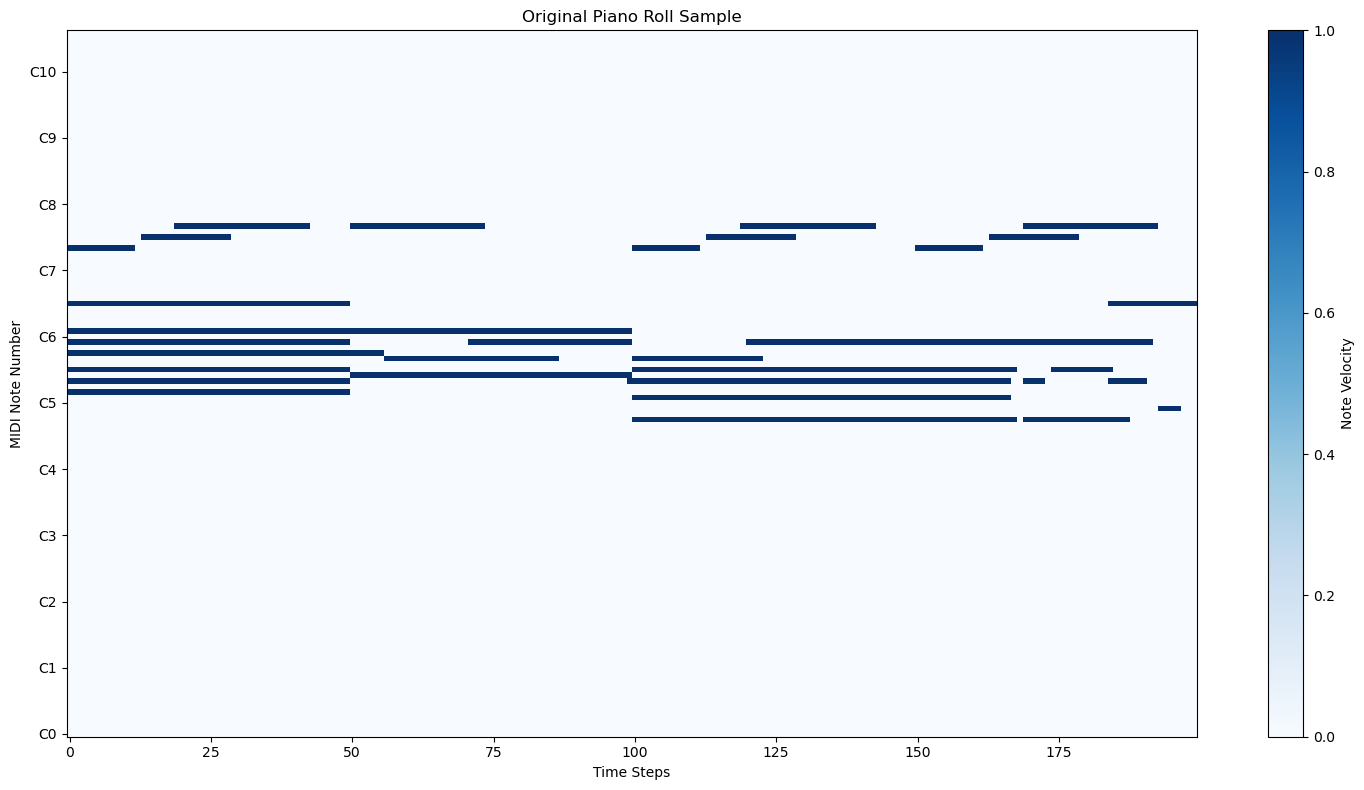


Generated music:


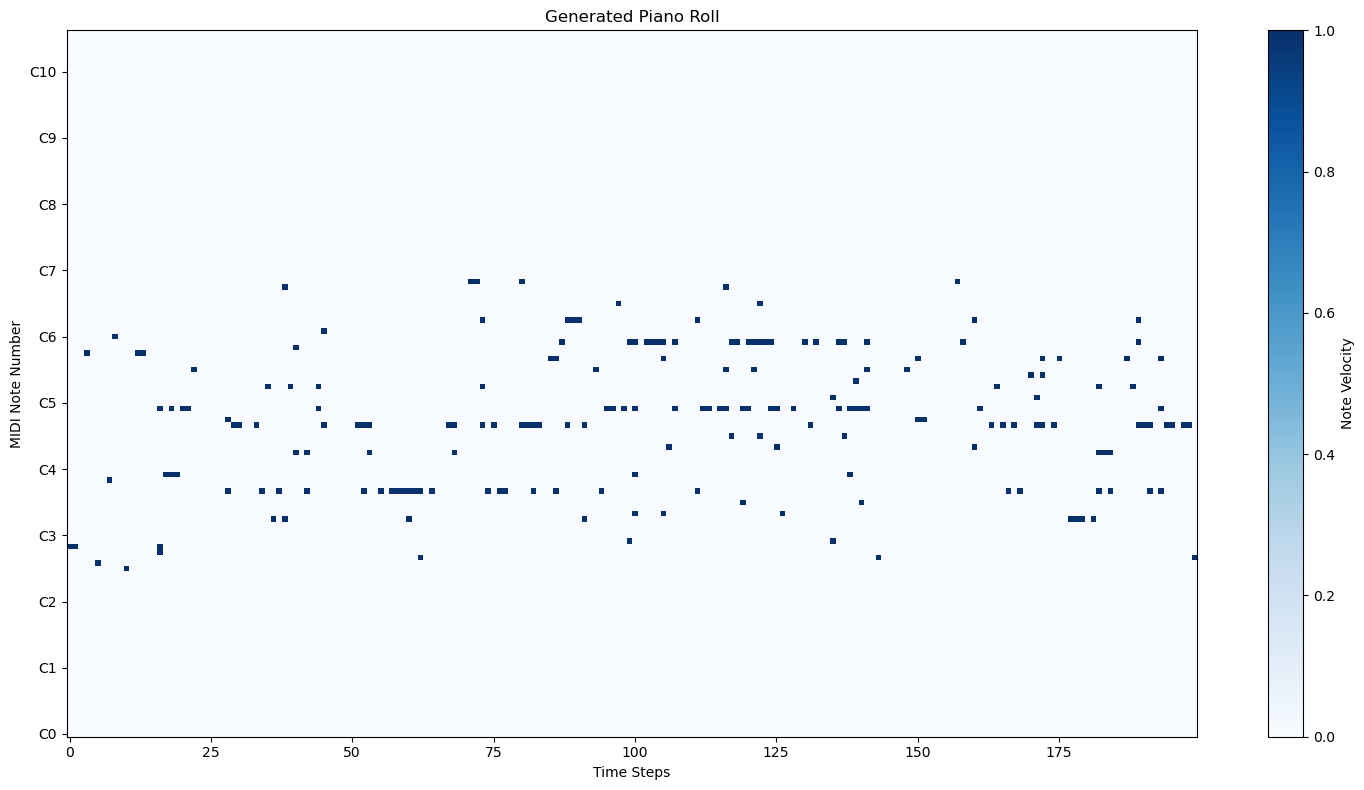

In [ ]:
def plot_piano_roll(piano_roll, title="Piano Roll", max_time=None):
    """Visualize piano roll"""
    if max_time:
        piano_roll = piano_roll[:max_time]
    
    plt.figure(figsize=(15, 8))
    plt.imshow(piano_roll.T, aspect='auto', origin='lower', cmap='Blues')
    plt.colorbar(label='Note Velocity')
    plt.xlabel('Time Steps')
    plt.ylabel('MIDI Note Number')
    plt.title(title)
    
    # Add note labels for reference
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave_ticks = [12 * i for i in range(11)]  # C0, C1, C2, etc.
    octave_labels = [f'C{i}' for i in range(11)]
    plt.yticks(octave_ticks, octave_labels)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Visualize original and generated music
print("Sample from training data:")
plot_piano_roll(piano_rolls[0][:200], "Original Piano Roll Sample", max_time=200)

print("\nGenerated music:")
plot_piano_roll(generated_sequence, "Generated Piano Roll", max_time=200)

In [ ]:
# Audio playback function with multiple fallback options
def play_midi_audio(midi_object, sample_rate=44100):
    """Convert MIDI to audio with multiple fallback methods"""
    
    try:
        audio_data = midi_object.synthesize(fs=sample_rate)
        if len(audio_data) > 0:
            print("✓ Using pretty_midi built-in synthesizer")
            return ipd.Audio(audio_data, rate=sample_rate)
    except Exception as e:
        print(f"Built-in synthesizer failed: {e}")

# Try to play the generated music
print("\nAttempting to play generated music...")
audio = play_midi_audio(generated_midi)
if audio:
    display(audio)
else:
    print("Error playing audio")

print(f"\nGeneration complete! Check 'generated_music.mid' for the output.")
print(f"Model type: {model.__class__.__name__}")
print(f"Generated sequence length: {len(generated_sequence)} time steps")
print(f"Total notes played: {np.sum(generated_sequence > 0.5)}")



Attempting to play generated music...
✓ Using pretty_midi built-in synthesizer



Generation complete! Check 'generated_music.mid' for the output.
Model type: Sequential
Generated sequence length: 300 time steps
Total notes played: 297
